# Dogs vs Cats

https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition

In [1]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import inception_resnet_v2

print(tf.__version__)
print(tf.executing_eagerly())

2.13.1
True


## Функции загрузки данных

In [2]:
import os
from random import shuffle
from glob import glob

IMG_SIZE = (224, 224)  # размер входного изображения сети

train_files = glob('data/train/*.jpg')
test_files = glob('data/test/*.jpg')

# загружаем входное изображение и предобрабатываем
def load_image(path, target_size=IMG_SIZE):
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, target_size)
    return inception_resnet_v2.preprocess_input(img)

# функция-генератор загрузки обучающих данных с диска
def fit_generator(files, batch_size=32):
    batch_size = min(len(files), batch_size)
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            X = np.array([load_image(path) for path in files[i:j]])
            y = np.array([1. if os.path.basename(path).startswith('dog') else 0. for path in files[i:j]])
            yield (X, y)

# функция-генератор загрузки тестовых изображений с диска
def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)])

## Визуализируем примеры для обучения

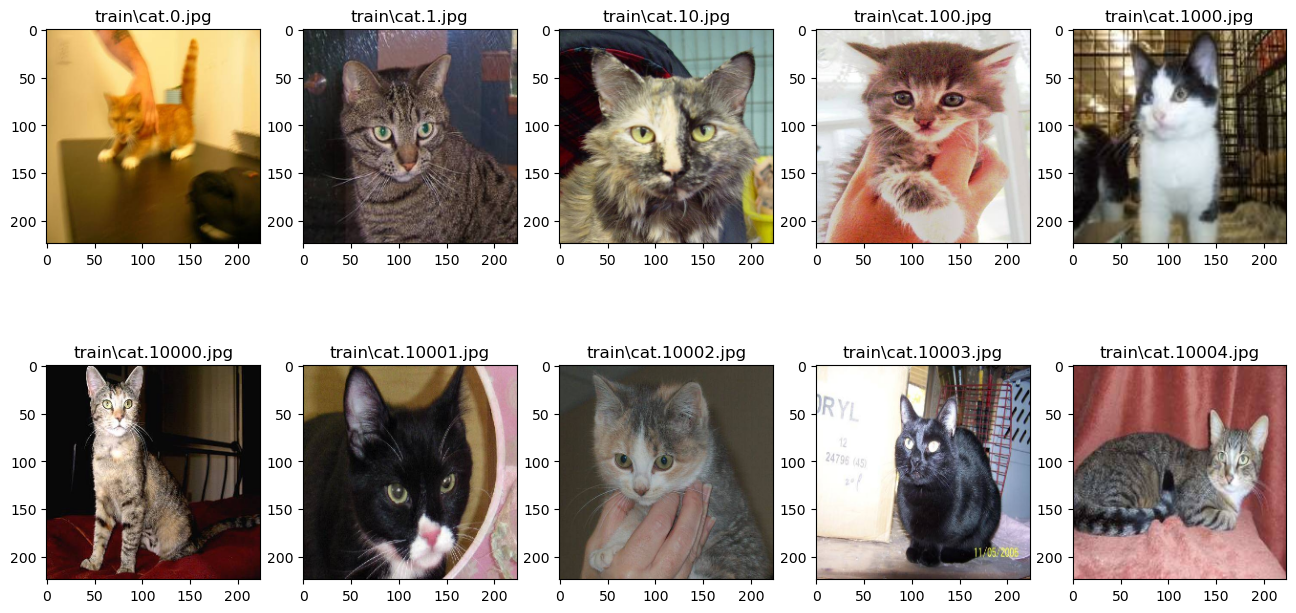

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(16, 8))
for i, path in enumerate(train_files[:10], 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%s' % path.split('/')[-1])
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    plt.imshow(img)

## Загружаем предобученную модель

In [4]:
# base_model - объект класса keras.models.Model (Functional Model)
base_model = inception_resnet_v2.InceptionResNetV2(weights='imagenet',
                                                   include_top=False,
                                                   input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

## Добавляем полносвязный слой

In [5]:
# фиксируем все веса предобученной сети
for layer in base_model.layers:
    layer.trainable = False

x = base_model.layers[-1].output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l1(1e-4))(x)

model = tf.keras.Model(inputs=base_model.input, outputs=x, name='cats_vs_dogs')

## Компилируем модель и запускаем обучение

In [6]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [7]:
callbacks = [tf.keras.callbacks.EarlyStopping(
    monitor="loss",
    min_delta=0,
    patience=5,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=0)]

val_samples = 8  # число изображений в валидационной выборке

shuffle(train_files)  # перемешиваем обучающую выборку
validation_data = next(fit_generator(train_files[:val_samples], val_samples))
train_data = fit_generator(train_files[val_samples:])  # данные читаем функцией-генератором

# запускаем процесс обучения
model.fit(train_data,
          steps_per_epoch=10,
          epochs=20,
          validation_data=validation_data,
          callbacks=callbacks)

Epoch 1/20
10/10 [==============================] - 44s 4s/step - loss: 0.1823 - accuracy: 0.9219 - val_loss: 0.0263 - val_accuracy: 1.0000
Epoch 2/20
10/10 [==============================] - 15s 2s/step - loss: 0.0935 - accuracy: 0.9906 - val_loss: 0.0277 - val_accuracy: 1.0000
Epoch 3/20
10/10 [==============================] - 27s 3s/step - loss: 0.1323 - accuracy: 0.9750 - val_loss: 0.0286 - val_accuracy: 1.0000
Epoch 4/20
10/10 [==============================] - 28s 3s/step - loss: 0.0884 - accuracy: 0.9875 - val_loss: 0.0293 - val_accuracy: 1.0000
Epoch 5/20
10/10 [==============================] - 17s 2s/step - loss: 0.2026 - accuracy: 0.9906 - val_loss: 0.0298 - val_accuracy: 1.0000
Epoch 6/20
10/10 [==============================] - 31s 3s/step - loss: 0.1256 - accuracy: 0.9906 - val_loss: 0.0301 - val_accuracy: 1.0000
Epoch 7/20
10/10 [==============================] - 14s 1s/step - loss: 0.1577 - accuracy: 0.9781 - val_loss: 0.0305 - val_accuracy: 1.0000
Epoch 8/20
10/10 [==

## Предсказания на проверочной выборке

In [13]:
test_pred = model.predict(
    predict_generator(test_files), steps=len(test_files))

12500/12500 [==============================] - 1251s 100ms/step


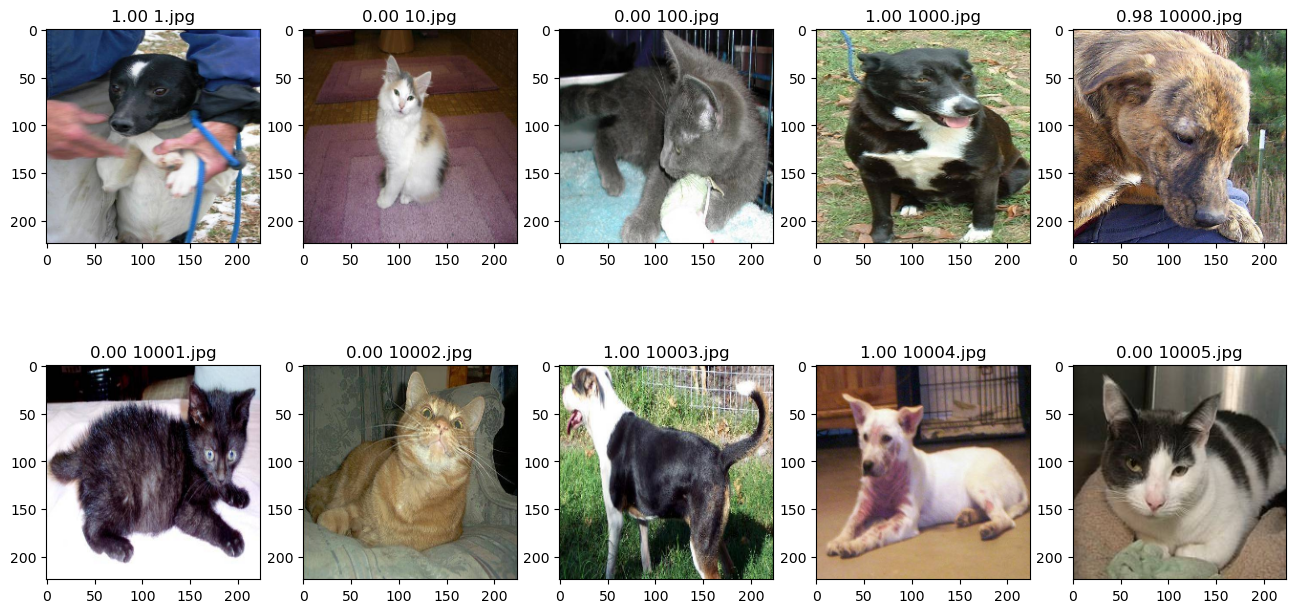

In [15]:
fig = plt.figure(figsize=(16, 8))
for i, (path, score) in enumerate(zip(test_files[:10], test_pred[:10]), 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%.2f %s' % (score, os.path.basename(path)))
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    subplot.imshow(img)

## Готовим данные для отправки

In [16]:
import re

with open('submit_inception_resnet.csv', 'w') as dst:
    dst.write('id,label\n')
    for path, score in zip(test_files, test_pred):
        dst.write('%s,%f\n' % (re.search('(\d+).jpg$', path).group(1), score))

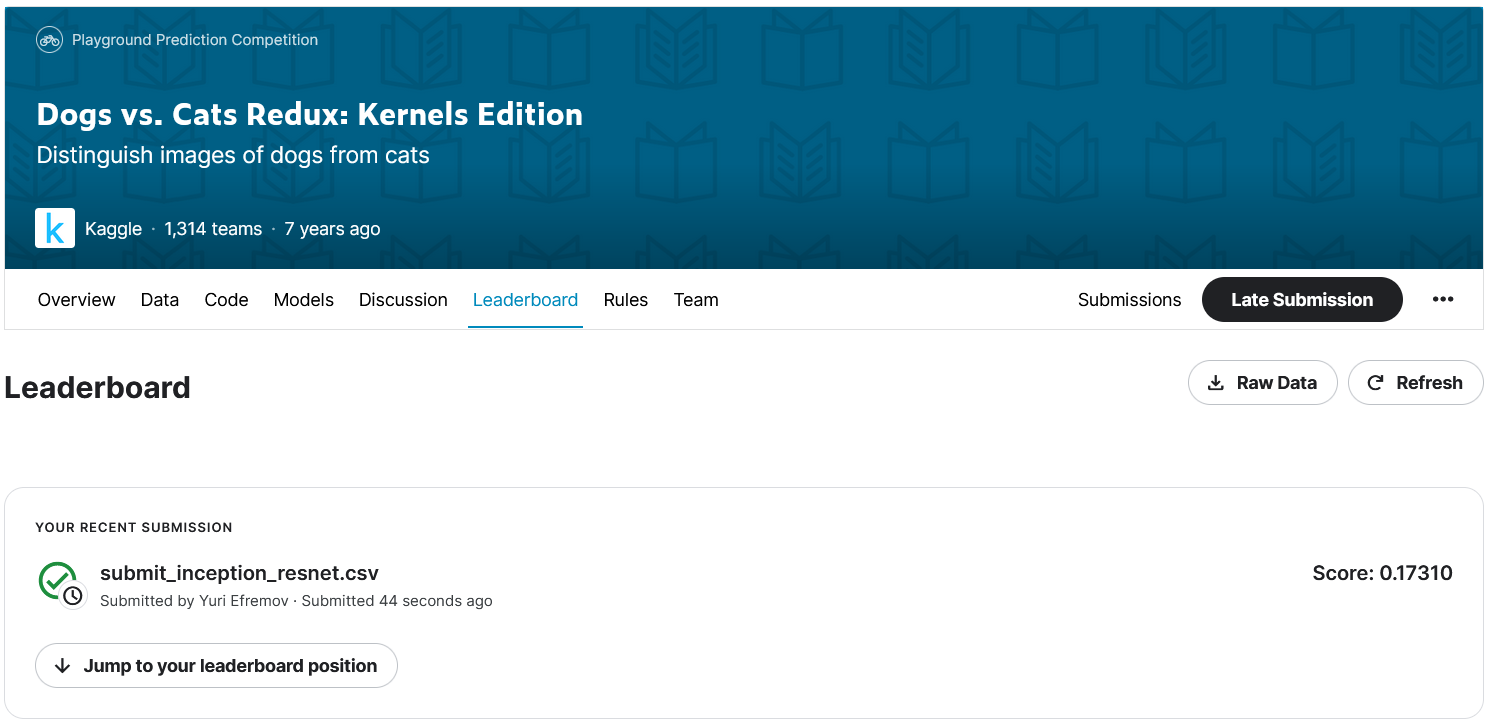